# Implementación del Problema de Optimización de Carteras con Computador Cuántico Adiabático con variables enteras

Este cuaderno describe la implementación de un problema de optimización de carteras de inversiones utilizando un computador cuántico adiabático. El enfoque adoptado es el del "Minimum Volatility Portfolio", utilizando variables binarias para la selección de activos. El objetivo principal es minimizar el riesgo total de la cartera, modelado por la fórmula:

$$\min \sum_{i,j} x_i \cdot w_{ij} \cdot x_j$$

donde $x_i$ representa la inclusión (1) o no (0) del activo $i$ en la cartera, y $w_{ij}$ es el término de covarianza entre los activos $i$ y $j$.

Además, se establece una restricción sobre el retorno esperado de la cartera, asegurando que sea al menos igual a un umbral predefinido. Esto se modela con una variable slack y se expresa como:

$$R \leq \sum_{i} x_i \cdot r_i$$

donde $r_i$ es el retorno esperado del activo $i$.

Finalmente, como condición adicional, se establece un presupuesto que se debe gastar en su totalidad. Esto se traduce en la restricción:

$$\sum_{i} x_i \cdot c_i = P$$

donde $c_i$ es el costo del activo $i$ y $P$ es el presupuesto total disponible para la inversión.


In [ ]:
!pip install -r "requirements_unix.txt"

Processing ./dadk_light_3.10.tar.bz2
  Preparing metadata (setup.py) ... done
  Created wheel for dadk: filename=dadk-2023.12.10-py3-none-any.whl size=4995459 sha256=7caeb9b97b0af4e56418e39d13e9c8e7a944faa243d4c58268e2b10c3ed0ce81
  Stored in directory: /tmp/pip-ephem-wheel-cache-1957r5wo/wheels/78/36/68/08dcbec0b48f137a33fc3ac474d3838f74984d2dda7e3178dd
Successfully built dadk
  Attempting uninstall: dadk
    Found existing installation: dadk 2023.12.10
    Uninstalling dadk-2023.12.10:
      Successfully uninstalled dadk-2023.12.10


In [ ]:
!pip install dimod > /dev/null 2>&1
!pip install pip-system-certs > /dev/null 2>&1
!pip install dwave-neal > /dev/null 2>&1
!pip install dwave-system > /dev/null 2>&1
!pip install hybrid > /dev/null 2>&1

In [ ]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
import random
from IPython.display import display, HTML
from dadk.Optimizer import *
from dadk.SolverFactory import *
from dadk.Solution_SolutionList import *
from dadk.BinPol import *
from random import uniform
from tabulate import tabulate
from numpy import argmax
import numpy as np
from dadk.QUBOSolverCPU import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import time

Para adaptar el código del problema al dataset mediano y mejorar la claridad y precisión de los cálculos, se han introducido varios cambios significativos:
  -  Los retornos se calculan como la diferencia porcentual entre el precio de cierre de las acciones y el precio de apertura. Luego, esos retornos se agrupan según el nombre de la empresa para calcular la media diraria y la matriz de covarianza.
  -  Los retornos esperados se obtienen directamente de los retornos medios calculados para cada empresa.

# Código Genérico

In [ ]:
asset_names = []
retornos_esperados = []
cov_matrix = []
solution = None
constraint_penalty = None
n_bits = 0

# Función para cargar y procesar datos
def cargar_datos(file_path):
    global asset_names, retornos_esperados, cov_matrix
    acciones = pd.read_csv(file_path)

    acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']
    retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()

    asset_names = retornos['Nombre de la Empresa'].tolist()

    retornos_esperados = np.array(retornos['retorno'].values)
    retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()

    cov_matrix = retornos_diarios.cov().values

    return asset_names, retornos_esperados, cov_matrix

# Función para configurar y ejecutar el modelo QUBO
def ejecutar_qubo(file_path, retorno_minimo=0.01, presupuesto_total=100, unidad_inversion=10, factor_penalty=1000, iterations=50000, runs=10):
    global solution, constraint_penalty, n_bits

    asset_names, retornos_esperados, cov_matrix = cargar_datos(file_path)
    n_assets = len(asset_names)

    max_unidades = 50 // unidad_inversion
    n_bits = int(np.ceil(np.log2(max_unidades + 1)))

    if not es_factible(retornos_esperados, retorno_minimo, n_assets):
        print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
        return

    QUBO, H_budget, H_slack = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, unidad_inversion, n_bits)

    solver = QUBOSolverCPU(
        number_iterations=iterations,
        number_runs=runs,
        scaling_bit_precision=16,
        auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
    )

    start_time = time.time()  # Inicia el temporizador antes de ejecutar el QUBO
    solution_list = solver.minimize(QUBO)
    end_time = time.time()  # Finaliza el temporizador después de ejecutar el QUBO

    print(solution_list.solver_times)

    constraint_penalty, solution = prep_result(solution_list, H_budget)
    report(constraint_penalty, solution, asset_names, retorno_minimo, unidad_inversion, n_bits)

    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")

# Función para construir el modelo QUBO
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, unidad_inversion, n_bits):
    var_problema = BitArrayShape('x', (n_assets, n_bits))

    slack_stop = presupuesto // unidad_inversion
    my_var_slack = VarSlack(name='slack_variable', start=0, step=1, stop=slack_stop, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(var_problema, my_var_slack)
    BinPol.freeze_var_shape_set(var_shape_set)

    # Construir H_cuad utilizando la matriz de covarianza
    H_cuad = BinPol()

    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits):
                for l in range(n_bits):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (unidad_inversion**2)
                    H_cuad.add_term(w_ij, ('x', i, k), ('x', j, l))

    # Construir H_slack para representar la restricción del retorno mínimo esperado
    H_slack = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_slack.add_term(retornos[i] * (2**k) * unidad_inversion, ('x', i, k))

    H_slack.add_slack_variable('slack_variable', factor=-1)
    H_slack.add_term(-retorno_min_esperado, ())

    # Construir H_buget para la restricción de gastar el presupuesto
    H_budget = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_budget.add_term((2**k) * unidad_inversion, ('x', i, k))
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty

    return QUBO, H_budget, H_slack

# Función para preparar y presentar el resultado
def prep_result(solution_list, H_budget, silent=False):
    solution = solution_list.min_solution
    constraint_penalty = H_budget.compute(solution.configuration)
    if not silent:
        print(f'\nValor QUBO: {constraint_penalty}')
        print(solution.configuration)
    return constraint_penalty, solution

# Función para reportar la solución
def report(constraint_penalty, solution, asset_names, retorno_min_esperado, unidad_inversion, n_bits, silent=False):
    if not silent:
        if constraint_penalty == 0.0:
            print('\nPortfolio elegido:')
            selected_assets = []
            for i in range(len(asset_names)):
                cantidad = sum(solution['x'][i, k] * (2**k) for k in range(n_bits))
                if cantidad > 0:
                    selected_assets.append((asset_names[i], cantidad * unidad_inversion))
            print(selected_assets)
            print()
        else:
            print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_min_esperado}")

# Función para verificar si el retorno mínimo es alcanzable
def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado


## Dataset Sintético

In [ ]:
ejecutar_qubo('Dataset_Acciones_Mediano.csv')

Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00512
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1931.000
  temperature_end:                   100.300
  offset_increase_rate:              344.100
  duration:                            0.005 sec
********************************************************************************

+--------------+----------------------------+----------------------------+----------------+
| time         | from                       | to                         | duration       |
|--------------+----------------------------+----------------------------+----------------|
| anneal       | 2024-06-

### Métricas

In [ ]:
# Cálculo de las métricas del portfolio
def metricas_portfolio(weights, retornos_esperados, cov_matrix, tasa_libre_riesgo=0.01, retorno_benchmark=0.05):
    retorno_portfolio = np.dot(weights, retornos_esperados)
    varianza_portfolio = np.dot(weights.T, np.dot(cov_matrix, weights))
    std_portfolio = np.sqrt(varianza_portfolio) # Desviación estándar

    # Cálculo ratio de Sharpe
    sharpe_ratio = (retorno_portfolio - tasa_libre_riesgo) / std_portfolio

    # Cálculo ratio de Sortino
    #retornos_negativos = retornos_esperados[retornos_esperados < 0]
    downside_risks = retornos_esperados.copy()  # Creamos una copia para modificarla
    downside_risks[downside_risks > 0] = 0  # Establecemos los retornos positivos a cero
    downside_deviation = np.sqrt(np.dot(weights.T, np.dot(np.diag(downside_risks**2), weights)))
    sortino_ratio = (retorno_portfolio - tasa_libre_riesgo) / downside_deviation if downside_deviation != 0 else 0

    # Cálculo ratio de información
    exceso_retorno = retorno_portfolio - retorno_benchmark
    std_exceso = std_portfolio
    information_ratio = exceso_retorno / std_exceso

    # Cálculo máxima caída
    max_drawdown = -np.min(np.cumsum(retornos_esperados) - np.maximum.accumulate(np.cumsum(retornos_esperados))) / np.maximum.accumulate(np.cumsum(retornos_esperados))

    # Calcular la diversificación
    num_activos_invertidos = np.sum(weights > 0)
    diversificacion = num_activos_invertidos / len(asset_names)

    return retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown, diversificacion, num_activos_invertidos

# Función de reporte de las métricas
def report_metricas(constraint_penalty, solution, asset_names, retorno_min_esperado, unidad_inversion, n_bits, retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown, diversificacion, num_activos_invertidos):
    print("Penalización por restricciones:", constraint_penalty)
    print("\nSolución del portfolio:")
    for i, name in enumerate(asset_names):
        cantidad = sum(solution['x'][i, k] * (2**k) for k in range(n_bits))  # Corrección aquí
        print(f" - {name}: {cantidad * unidad_inversion} unidades")  # Muestra unidades correctamente
    print("\nRetorno del Portfolio:", retorno_portfolio)
    print("\nVarianza del Portfolio:", varianza_portfolio)
    print("\nRatio de Sharpe:", sharpe_ratio)
    print("\nRatio de Sortino:", sortino_ratio)
    print("\nRatio de Información:", information_ratio)
    print("\nMáxima Caída:", max_drawdown)
    print(f"\nDiversificación del Portfolio: {diversificacion:.2f} (activos seleccionados: {num_activos_invertidos} de {len(asset_names)})")

weights = np.array([np.sum([(2**k) * solution['x'][i, k] for k in range(n_bits)]) for i in range(len(asset_names))], dtype=float)
weights /= np.sum(weights)

retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown, diversificacion, num_activos_invertidos = metricas_portfolio(weights, retornos_esperados, cov_matrix)

report_metricas(constraint_penalty, solution, asset_names, 0.02, 10, n_bits, retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown, diversificacion, num_activos_invertidos)


Penalización por restricciones: 0

Solución del portfolio:
 - Empresa A: 0 unidades
 - Empresa B: 0 unidades
 - Empresa C: 0 unidades
 - Empresa D: 0 unidades
 - Empresa E: 20 unidades
 - Empresa F: 70 unidades
 - Empresa G: 10 unidades

Retorno del Portfolio: 0.09466420820500103

Varianza del Portfolio: 0.5663252648377641

Ratio de Sharpe: 0.11250371996698597

Ratio de Sortino: 1.1435622242131682

Ratio de Información: 0.05935081280481138

Máxima Caída: [0.02132409 0.01464865 0.00816856 0.00677353 0.00654943 0.00654943
 0.00634791]

Diversificación del Portfolio: 0.43 (activos seleccionados: 3 de 7)


<ipython-input-126-27d91e72dde6>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


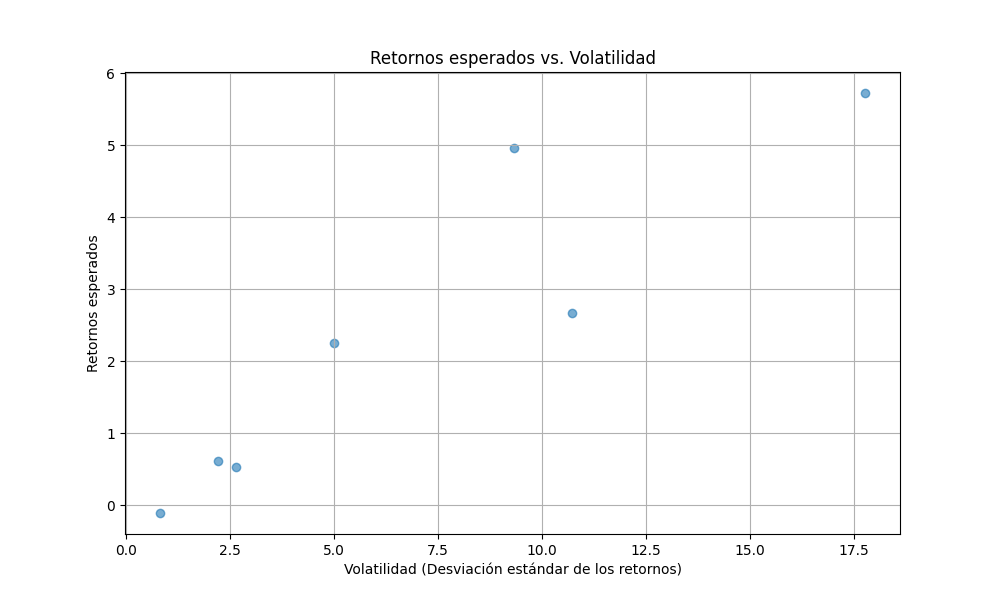

In [ ]:
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()

volatilidades = np.sqrt(np.diag(cov_matrix))

plt.figure(figsize=(10, 6))
plt.scatter(volatilidades, retornos_esperados, alpha=0.6)
plt.title('Retornos esperados vs. Volatilidad')
plt.xlabel('Volatilidad (Desviación estándar de los retornos)')
plt.ylabel('Retornos esperados')
plt.grid(True)
plt.show()

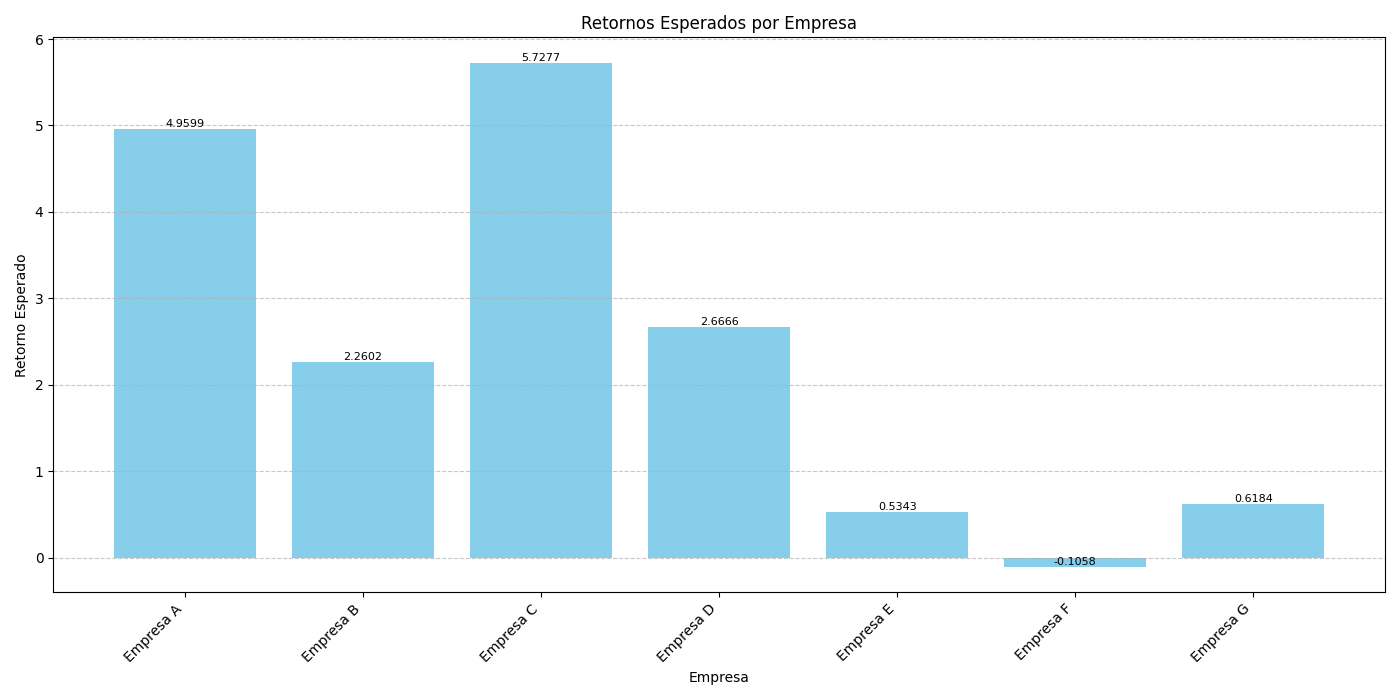

In [ ]:
# Asumiendo que 'asset_names' contiene los nombres de las empresas y 'retornos_esperados' los retornos correspondientes
plt.figure(figsize=(14, 7))  # Ajusta el tamaño de la figura según la cantidad de activos
bars = plt.bar(asset_names, retornos_esperados, color='skyblue')
plt.title('Retornos Esperados por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Retorno Esperado')
plt.xticks(rotation=45, ha="right")  # Rota los nombres de las empresas para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añade el valor de cada barra sobre ella para mejor claridad
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=8)

plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama para dar espacio a los nombres de empresa
plt.show()


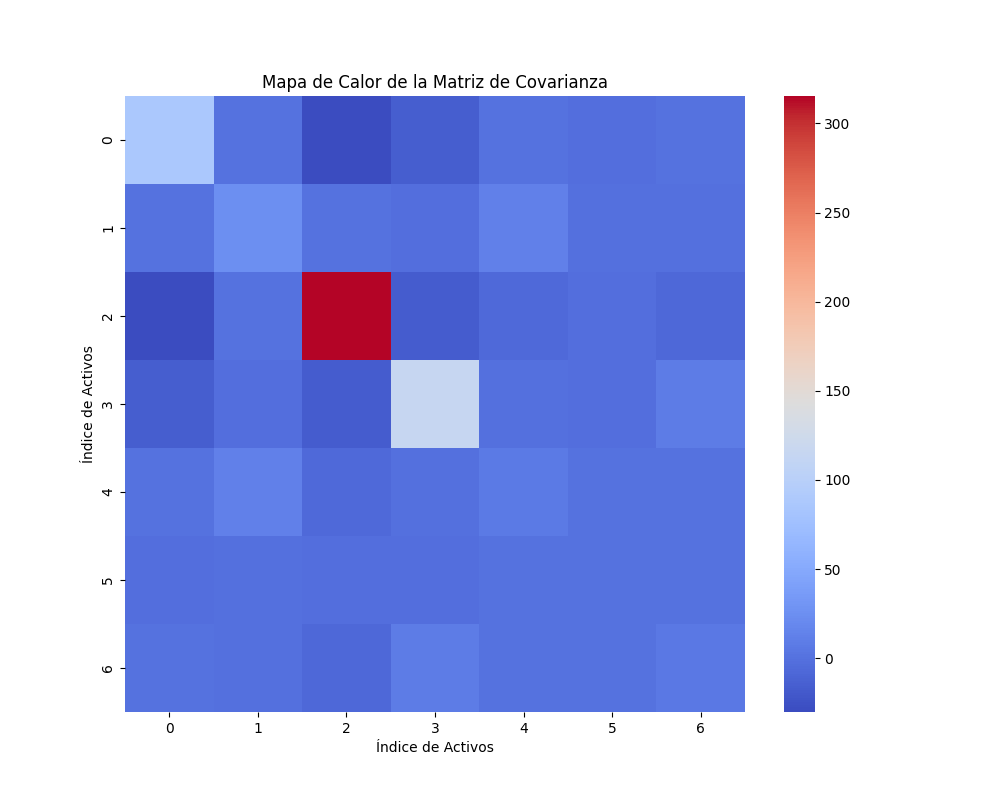

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de la Matriz de Covarianza')
plt.xlabel('Índice de Activos')
plt.ylabel('Índice de Activos')
plt.show()


### Ejecución en D-Wave

In [ ]:
# experimental:start
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    The polynomial is returned as a :class:`dimod.BinaryQuadraticModel` object.

    :return: qubo as dimod.BinaryQuadraticModel object
    :rtype: dimod.BinaryQuadraticModel
    """

    try:
        import dimod
    except Exception as oops:
        print('\n\n' + (100 * '#'))
        print('pip install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise oops

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)


In [ ]:
bqm_problem=QUBO.as_bqm()

In [ ]:
os.environ['DWAVE_API_TOKEN']='DEV-8118e94d4ee0db7e32f9198eb7e865c8a30acfa5'

#### Solver Híbrido

In [ ]:
# Configuración del sampler de D-Wave
import os
from dwave.system import LeapHybridSampler

# Mide el tiempo de muestreo
sample_time = time.time()

sampler = LeapHybridSampler()

# Muestreo del problema BQM
answer = sampler.sample(bqm_problem)

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in answer.data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

Configuración de solución:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 1, 27: 0, 28: 0, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1}
Energía:  -13059.2715970336
Tiempo de muestreo: 9.46491289138794


#### Solver Cuántico

In [ ]:
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler

# Mide el tiempo de muestreo
sample_time = time.time()

# Configuración del sampler de D-Wave QPU
sampler = EmbeddingComposite(DWaveSampler())

# Número de lecturas
num_reads = 2000

# Muestreo del problema BQM
sampleset = sampler.sample(bqm_problem, num_reads=num_reads, label='Purely Quantum Exec')

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in sampleset.lowest().data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

Configuración de solución:  {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1}
Energía:  -8742.905520734377
Tiempo de muestreo: 13.538281202316284


## Dataset Real

In [ ]:
ejecutar_qubo('Dataset_Acciones_Empresas.csv')

Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00512
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1530.000
  temperature_end:                    98.860
  offset_increase_rate:              316.100
  duration:                            0.003 sec
********************************************************************************

+--------------+----------------------------+----------------------------+----------------+
| time         | from                       | to                         | duration       |
|--------------+----------------------------+----------------------------+----------------|
| anneal       | 2024-06-

### Métricas

In [ ]:
# Calculations for the portfolio metrics
def metricas_portfolio(weights, retornos_esperados, cov_matrix, tasa_libre_riesgo=0.01, retorno_benchmark=0.05):
    # Asegurar que 'weights' y 'retornos_esperados' tienen la misma longitud
    n_activos = min(len(weights), len(retornos_esperados))
    weights = weights[:n_activos]
    retornos_esperados = retornos_esperados[:n_activos]
    cov_matrix = cov_matrix[:n_activos, :n_activos] # Ajustar cov_matrix también

    retorno_portfolio = np.dot(weights, retornos_esperados) * (-1)
    varianza_portfolio = np.dot(weights.T, np.dot(cov_matrix, weights))
    std_portfolio = np.sqrt(varianza_portfolio) # Desviación estándar

    # Cálculo ratio de Sharpe
    sharpe_ratio = (retorno_portfolio - tasa_libre_riesgo) / std_portfolio

    # Cálculo ratio de Sortino
    #retornos_negativos = retornos_esperados[retornos_esperados < 0]
    downside_risks = retornos_esperados.copy()  # Creamos una copia para modificarla
    downside_risks[downside_risks > 0] = 0  # Establecemos los retornos positivos a cero
    downside_deviation = np.sqrt(np.dot(weights.T, np.dot(np.diag(downside_risks**2), weights)))
    sortino_ratio = (retorno_portfolio - tasa_libre_riesgo) / downside_deviation if downside_deviation != 0 else 0

    # Cálculo ratio de información
    exceso_retorno = retorno_portfolio - retorno_benchmark
    std_exceso = std_portfolio
    information_ratio = exceso_retorno / std_exceso

    # Cálculo máxima caída
    max_drawdown = -np.min(np.cumsum(retornos_esperados) - np.maximum.accumulate(np.cumsum(retornos_esperados))) / np.maximum.accumulate(np.cumsum(retornos_esperados))

    return retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown

# Función para reportar las métricas del portafolio ajustada para mostrar correctamente las unidades de cada empresa
def report_metricas(constraint_penalty, solution, asset_names, retorno_min_esperado, unidad_inversion, n_bits, retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown):
    print("Penalización por restricciones:", constraint_penalty)
    print("\nSolución del portfolio:")
    for i, name in enumerate(asset_names):
        cantidad = sum(solution['x'][i, k] * (2**k) for k in range(n_bits))  # Corrección aquí
        print(f" - {name}: {cantidad * unidad_inversion} unidades")  # Muestra unidades correctamente
    print("\nRetorno del Portfolio:", retorno_portfolio)
    print("\nVarianza del Portfolio:", varianza_portfolio)
    print("\nRatio de Sharpe:", sharpe_ratio)
    print("\nRatio de Sortino:", sortino_ratio)
    print("\nRatio de Información:", information_ratio)
    print("\nMáxima Caída:", max_drawdown)


n_activos = solution['x'].shape[0]  # Número real de activos según los datos en 'solution['x']'
n_bits = solution['x'].shape[1]

# Reducir 'asset_names' a los nombres correspondientes a los activos en 'solution['x']'
asset_names = asset_names[:n_activos]  # Asume que los primeros n_activos nombres son los correctos

# Código para calcular los pesos y reportar métricas se mantiene igual
weights = np.array([np.sum([(2**k) * solution['x'][i, k] for k in range(n_bits)]) for i in range(n_activos)], dtype=float)
weights /= np.sum(weights)  # Normalizar los pesos para que sumen 1

retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown = metricas_portfolio(weights, retornos_esperados, cov_matrix)

report_metricas(constraint_penalty, solution, asset_names, 0.02, 10, n_bits, retorno_portfolio, varianza_portfolio, sharpe_ratio, sortino_ratio, information_ratio, max_drawdown)

Penalización por restricciones: 0

Solución del portfolio:
 - Empresa A: 0 unidades
 - Empresa B: 30 unidades
 - Empresa C: 20 unidades
 - Empresa D: 0 unidades
 - Empresa E: 0 unidades
 - Empresa F: 20 unidades
 - Empresa G: 0 unidades
 - Empresa H: 0 unidades
 - Empresa I: 30 unidades
 - Empresa J: 0 unidades

Retorno del Portfolio: 0.021641959494145383

Varianza del Portfolio: 0.00010273354011653592

Ratio de Sharpe: 1.148603028395114

Ratio de Sortino: 1.0559592125261459

Ratio de Información: -2.797822069451118

Máxima Caída: [-3.4084842  -3.4084842  -3.4084842  -3.4084842  -3.69206304 -3.69206304
 -3.69206304  9.84194931  9.84194931  1.16586814]


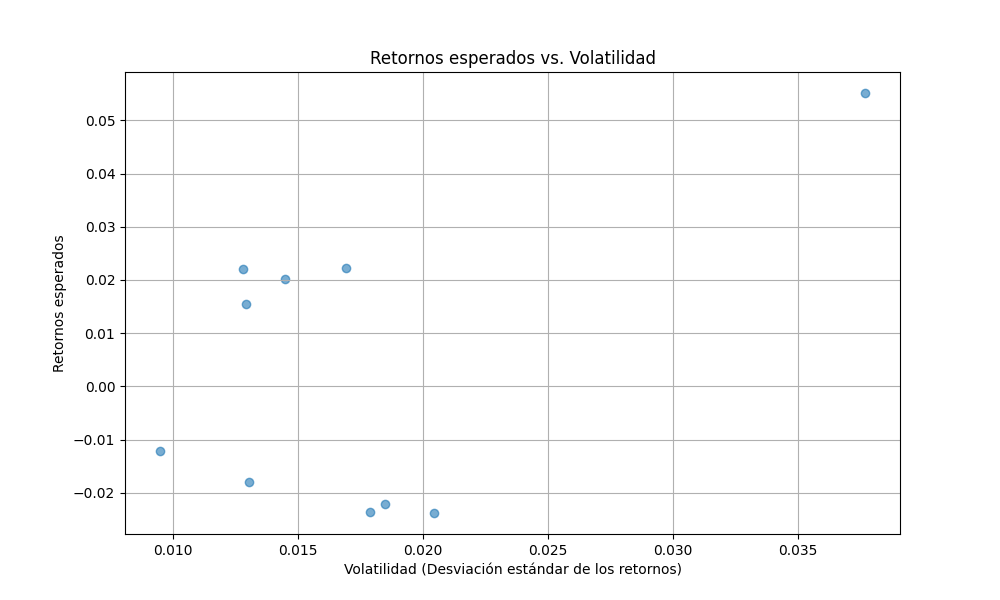

In [ ]:
volatilidades = np.sqrt(np.diag(cov_matrix))

plt.figure(figsize=(10, 6))
plt.scatter(volatilidades, retornos_esperados, alpha=0.6)
plt.title('Retornos esperados vs. Volatilidad')
plt.xlabel('Volatilidad (Desviación estándar de los retornos)')
plt.ylabel('Retornos esperados')
plt.grid(True)
plt.show()

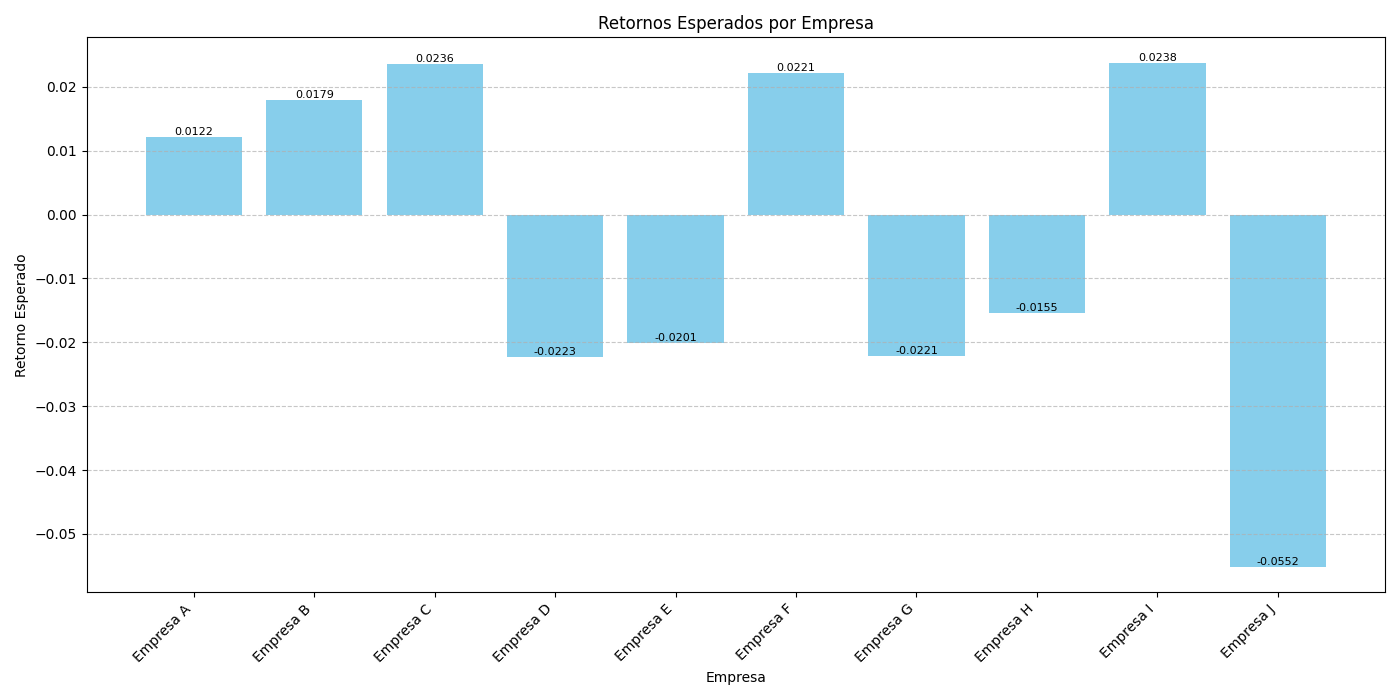

In [ ]:
# Asumiendo que 'asset_names' contiene los nombres de las empresas y 'retornos_esperados' los retornos correspondientes
plt.figure(figsize=(14, 7))  # Ajusta el tamaño de la figura según la cantidad de activos
bars = plt.bar(asset_names, retornos_esperados*(-1), color='skyblue')
plt.title('Retornos Esperados por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Retorno Esperado')
plt.xticks(rotation=45, ha="right")  # Rota los nombres de las empresas para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añade el valor de cada barra sobre ella para mejor claridad
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=8)

plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama para dar espacio a los nombres de empresa
plt.show()


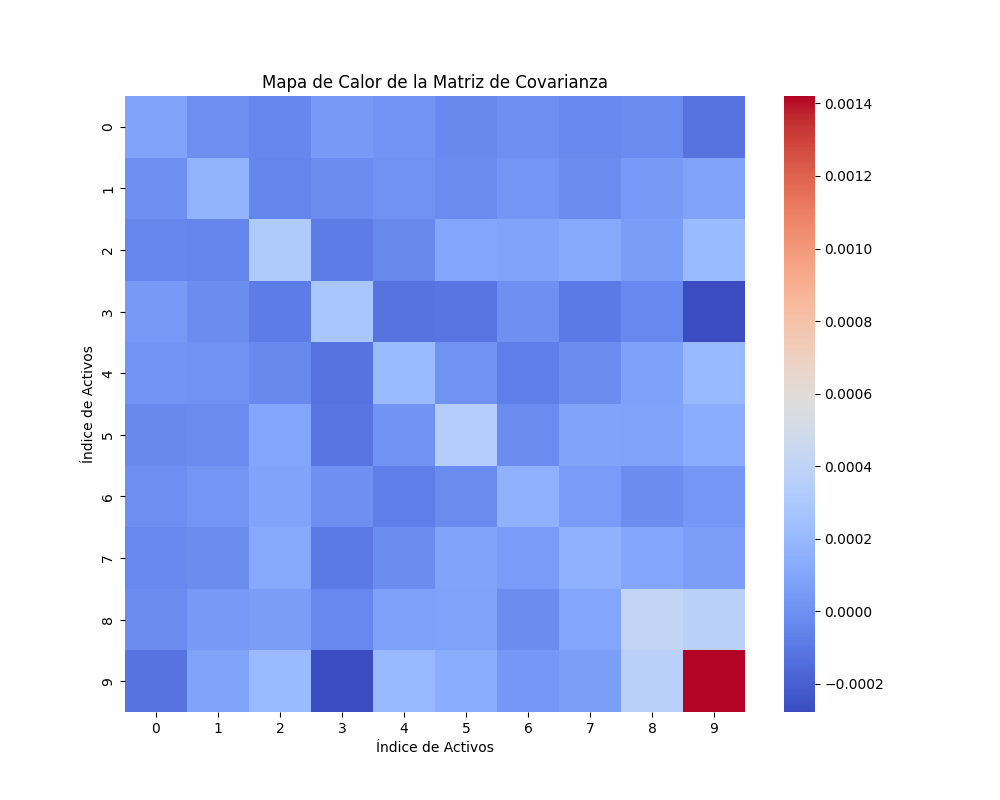

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de la Matriz de Covarianza')
plt.xlabel('Índice de Activos')
plt.ylabel('Índice de Activos')
plt.show()


### Ejecución en D-Wave

In [ ]:
# experimental:start
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    The polynomial is returned as a :class:`dimod.BinaryQuadraticModel` object.

    :return: qubo as dimod.BinaryQuadraticModel object
    :rtype: dimod.BinaryQuadraticModel
    """

    try:
        import dimod
    except Exception as oops:
        print('\n\n' + (100 * '#'))
        print('pip install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise oops

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)


In [ ]:
bqm_problem=QUBO.as_bqm()

#### Solver Híbrido

In [ ]:
# Mide el tiempo de muestreo
sample_time = time.time()

sampler = LeapHybridSampler()

# Muestreo del problema BQM
answer = sampler.sample(bqm_problem)

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in answer.data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

Configuración de solución:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 1, 27: 0, 28: 0, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1}
Energía:  -13059.2715970336
Tiempo de muestreo: 7.894184589385986


#### Solver Cuántico

In [ ]:
# Mide el tiempo de muestreo
sample_time = time.time()

# Configuración del sampler de D-Wave QPU
sampler = EmbeddingComposite(DWaveSampler())

# Número de lecturas
num_reads = 2000

# Muestreo del problema BQM
sampleset = sampler.sample(bqm_problem, num_reads=num_reads, label='Purely Quantum Exec')

# Calcula el tiempo de muestreo
sample_time = time.time() - sample_time

# Análisis de la solución
for datum in sampleset.lowest().data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)

print("Tiempo de muestreo:", sample_time)

Configuración de solución:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 0, 24: 0, 25: 1, 26: 0, 27: 0, 28: 0, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1}
Energía:  -10685.274696868495
Tiempo de muestreo: 8.634477853775024
